In [2]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("glmnet")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpqVaPRI/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpqVaPRI/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpqVaPRI/downloaded_packages


In [3]:
library(dplyr)
library(glmnet)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.1-8



# Import, format, scale data

In [4]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
data$scaled_score <- (data$score_min -1)/4
data$logistic_transformed_score <-  1 / (1 + exp(-data$scaled_score))
trim_data <- data %>% select(-identifier,-score_min, - scaled_score,  -serviceable_agg, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
min_max_scale <- function(x) {
  (x - min(x)) / (max(x) - min(x))
}

# Apply the min-max scaling to all columns except logistic_transformed_score
scaled_data <- trim_data %>%
  mutate(across(-logistic_transformed_score, min_max_scale))

# Build a model

In [5]:
model <- lm(logistic_transformed_score ~ ., data = scaled_data)
fit_aic <- step(model)
summary(fit_aic)

Start:  AIC=-564.46
logistic_transformed_score ~ IT01V_packetsRecieved_ellen + IT01V_packetsRecieved_aadya + 
    IT01V_packetsLost_ellen + IT01V_packetsLost_aadya + IT01V_frameWidth_ellen + 
    IT01V_frameWidth_aadya + IT01V_frameHeight_ellen + IT01V_frameHeight_aadya + 
    IT01V_totalFreezesDuration_ellen + IT01V_totalFreezesDuration_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_bytesReceived_in_bits_s_ellen + IT01V_bytesReceived_in_bits_s_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitter_ellen + IT01V_jitter_aadya + IT01V_jitterBufferDelay_emissions_ellen + 
    IT01V_jitterBufferDelay_emissions_aadya + IT01A_bytesReceived_in_bits_s_ellen + 
    IT01A_bytesReceived_in_bits_s_aadya + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_packetsSent_s_aadya + OT01V_bytesSent_in_bits_s_ellen + 
    OT01V_bytesSent_in_bits_s


Call:
lm(formula = logistic_transformed_score ~ IT01V_packetsLost_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitterBufferDelay_emissions_ellen + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_bytesSent_in_bits_s_ellen + OT01V_framesPerSecond_ellen + 
    OT01V_framesPerSecond_aadya + OT01V_totalPacketSendDelay_ellen + 
    RIV_roundTripTime_aadya + RIV_fractionLost_ellen + RIA_fractionLost_aadya + 
    RIA_roundTripTime_aadya + AP_totalPlayoutDelay_ellen, data = scaled_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07130 -0.01663  0.00031  0.01897  0.07109 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                              0.65955    0.03513  18.773  < 2e-16
IT01V_packetsLost_aadya                  0.05146 

# scale data

In [6]:
scale_cols <- function(stage_data) {
    # Columns to conditionally exclude if they exist
    exclude_cols <- c("identifier", "Condition")
    # Only exclude columns that exist in the dataframe
    existing_exclude_cols <- intersect(exclude_cols, colnames(stage_data))
    # Remove only the columns that exist
    trim_data <- stage_data %>% select(-all_of(existing_exclude_cols))
    
    # Define a custom min-max scaling function
    min_max_scale <- function(x) {
        if (length(unique(x)) > 1) {
            (x - min(x)) / (max(x) - min(x))
        } else {
            x  # Return the original value if there's no variance
        }
    }
    
    # Check if 'Upload_x' is a column in the data
    if ("Upload_x" %in% colnames(trim_data)) {
        # Use the 'Upload_x', 'Download_x', 'Latency_x' columns
        scaled_data <- trim_data %>%
            mutate(across(-c(Upload_x, Download_x, Latency_x, Upload_y, Download_y, Latency_y), min_max_scale))
    } else {
        # Use the 'Upload', 'Download', 'Latency' columns
        scaled_data <- trim_data %>%
            mutate(across(-c(Upload, Download, Latency), min_max_scale))
    }
    
    # Return the scaled data
    return(scaled_data)
}

# import and execute scaling

In [9]:
stage_1<- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_1_regression_table.csv"))
stage_2 <- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_2_regression_table.csv"))
stage_3 <- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_3_regression_table.csv"))


# infer values

In [10]:
stage_1$score <- predict(fit_aic, newdata = stage_1)
stage_2$score <- predict(fit_aic, newdata = stage_2)
stage_3$score <- predict(fit_aic, newdata = stage_3)

# create log terms

In [35]:
log_terms <- function(stage_data) {
    # Create log-transformed columns based on the presence of 'Upload_x'
    if ("Upload_x" %in% colnames(stage_data)) {
        stage_data$log_up_x <- log(stage_data$Upload_x)
        stage_data$log_up_y <- log(stage_data$Upload_y)
        stage_data$log_down_x <- log(stage_data$Download_x)
        stage_data$log_down_y <- log(stage_data$Download_y)
        
        # Create a custom min-max scaling function
        min_max_scale <- function(x) {
            if (length(unique(x)) > 1) {
                (x - min(x)) / (max(x) - min(x))
            } else {
                x  # Return the original value if there's no variance
            }
        }
        
        # Create new scaled columns using min-max scaling
        stage_data <- stage_data %>%
            mutate(log_up_x_scaled = min_max_scale(log_up_x),
                   log_up_y_scaled = min_max_scale(log_up_y),
                   log_down_x_scaled = min_max_scale(log_down_x),
                   log_down_y_scaled = min_max_scale(log_down_y),
                   latency_y_scaled = min_max_scale(Latency_y),
                   latency_x_scaled = min_max_scale(Latency_x))
                   
    } else {
        stage_data$log_up <- log(stage_data$Upload)
        stage_data$log_down <- log(stage_data$Download)
        
        # Create new scaled columns using min-max scaling
        stage_data <- stage_data %>%
            mutate(log_up_scaled = min_max_scale(log_up),
                   log_down_scaled = min_max_scale(log_down),
                   latency_scaled = min_max_scale(Latency))
    }
    
    # Return the modified data with log and scaled columns
    return(stage_data)
}


In [36]:
stage_1 <- log_terms(stage_1)
stage_2 <- log_terms(stage_2)
stage_3 <- log_terms(stage_3)

In [37]:
new_model1 <- lm(score ~ log_up_scaled + log_down_scaled + latency_scaled, data = stage_1)
new_model2 <- lm(score ~ log_up_scaled + log_down_scaled + latency_scaled, data = stage_2)
new_model3 <- lm(score ~ log_up_x_scaled + log_down_x_scaled + latency_x_scaled + log_up_y_scaled + log_down_y_scaled + latency_y_scaled, data = stage_3)

In [38]:
summary(new_model1)
summary(new_model2)
summary(new_model3)

calculate_mse <- function(stage, model) {
    predictions <- predict(model, stage)
    mse <- mean((stage$score - predictions)^2)
    stage_name <- deparse(substitute(stage))
    return(paste(stage_name, mse, sep= " "))
}
calculate_mse(stage_1, new_model1)
calculate_mse(stage_2, new_model2)
calculate_mse(stage_3, new_model3)


Call:
lm(formula = score ~ log_up_scaled + log_down_scaled + latency_scaled, 
    data = stage_1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.91554 -0.04862  0.03063  0.09990  0.33296 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.71643    0.02672  26.815  < 2e-16 ***
log_up_scaled    0.12275    0.02719   4.514 9.19e-06 ***
log_down_scaled -0.06421    0.02982  -2.153   0.0321 *  
latency_scaled   0.25750    0.03022   8.521 8.28e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1824 on 295 degrees of freedom
Multiple R-squared:  0.2491,	Adjusted R-squared:  0.2415 
F-statistic: 32.63 on 3 and 295 DF,  p-value: < 2.2e-16



Call:
lm(formula = score ~ log_up_scaled + log_down_scaled + latency_scaled, 
    data = stage_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59372 -0.05626  0.01460  0.07215  0.55248 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.59472    0.03197  18.604  < 2e-16 ***
log_up_scaled    0.11016    0.03245   3.394 0.000784 ***
log_down_scaled -0.07224    0.03544  -2.038 0.042434 *  
latency_scaled  -0.09152    0.03583  -2.554 0.011151 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2145 on 288 degrees of freedom
Multiple R-squared:  0.07157,	Adjusted R-squared:  0.0619 
F-statistic: 7.401 on 3 and 288 DF,  p-value: 8.59e-05



Call:
lm(formula = score ~ log_up_x_scaled + log_down_x_scaled + latency_x_scaled + 
    log_up_y_scaled + log_down_y_scaled + latency_y_scaled, data = stage_3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.89351 -0.08043  0.04140  0.14741  0.33053 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.60431    0.04510  13.399  < 2e-16 ***
log_up_x_scaled    0.02908    0.03382   0.860  0.39052    
log_down_x_scaled -0.01702    0.03689  -0.461  0.64482    
latency_x_scaled   0.18292    0.03825   4.782 2.78e-06 ***
log_up_y_scaled    0.09044    0.03405   2.656  0.00835 ** 
log_down_y_scaled -0.03195    0.03707  -0.862  0.38946    
latency_y_scaled   0.19347    0.03825   5.059 7.56e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2237 on 286 degrees of freedom
Multiple R-squared:  0.1625,	Adjusted R-squared:  0.1449 
F-statistic: 9.249 on 6 and 286 DF,  p-value: 2.872e-09


[1] "stage_1 0.0328277887699201"

[1] "stage_2 0.0453708162865143"

[1] "stage_3 0.0488465576018641"

# undo the logistic transform

In [13]:
transform_scores <- function(stage_data) {
  #ensure strictly between 0 and 1 to avoid undefined
  stage_data$score <- pmax(pmin(stage_data$score, 0.999), 0.001) 
  #apply logit transform to put back into normalised score form
  stage_data$real_score <-log(stage_data$score / (1 - stage_data$score))
  #then scale back up to 1-5
  stage_data$real_score_multiplied <- ((stage_data$real_score * 4) + 1)
  return(stage_data)
}
stage_1 <- transform_scores(stage_1)
stage_2 <- transform_scores(stage_2)
stage_3 <- transform_scores(stage_3)

# add a binary column that defines serviceability

In [14]:
create_binary_grouping <- function(stage_data) {
  stage_data$binary_col <- ifelse(stage_data$real_score_multiplied < 3, 0, 1)
  
  unserv_0 <- subset(stage_data, binary_col == 0)
  serv_1 <- subset(stage_data, binary_col == 1)
  
  unserv_0$group <- paste("UNSERV")
  serv_1$group <- paste("SERV")
  
  combined_data <- rbind(unserv_0, serv_1)
  return(combined_data)
}
#execute for each stage
combined_data1 <- create_binary_grouping(stage_1)
combined_data2 <- create_binary_grouping(stage_2)
combined_data3 <- create_binary_grouping(stage_3)

In [15]:
#show distribution of 0s and 1s
table(combined_data1$binary_col)
table(combined_data2$binary_col)
table(combined_data3$binary_col)


  0   1 
 25 274 


  0   1 
179 113 


  0   1 
 46 247 

# factors

In [16]:
create_factors <- function(data) {
    upload_levels <- c(500, 1000, 5000, 20000)
    latency_levels <-  c(100, 250, 400, 550, 750)
    download_levels <- c(2000, 5000, 12000, 25000, 50000)
    data$Upload_Factor <- factor(data$Upload, levels = upload_levels)
    data$Download_Factor <- factor(data$Download, levels = download_levels)
    data$Latency_Factor <- factor(data$Latency, levels = latency_levels)
  return(data)
}
combined_data1 <- create_factors(combined_data1)
combined_data2 <- create_factors(combined_data2)

create_factors3 <- function(data) {
    upload_levels <- c(500, 1000, 5000, 20000)
    latency_levels <-  c(100, 250, 400, 550, 750)
    download_levels <- c(2000, 5000, 12000, 25000, 50000)
    data$Upload_Factor_x <- factor(data$Upload_x, levels = upload_levels)
    data$Upload_Factor_y <- factor(data$Upload_y, levels = upload_levels)
    data$Latency_Factor_x <- factor(data$Latency_x, levels = latency_levels)
    data$Latency_Factor_y <- factor(data$Latency_y, levels = latency_levels)
    data$Download_Factor_x <- factor(data$Download_x, levels = download_levels)
    data$Download_Factor_y <- factor(data$Download_y, levels = download_levels)
  return(data)
}
combined_data3 <- create_factors3(combined_data3)


In [24]:
serv1 <-subset(combined_data1,binary_col == 1)
serv2 <- subset(combined_data2,binary_col == 1)
serv3 <- subset(combined_data3,binary_col == 1)

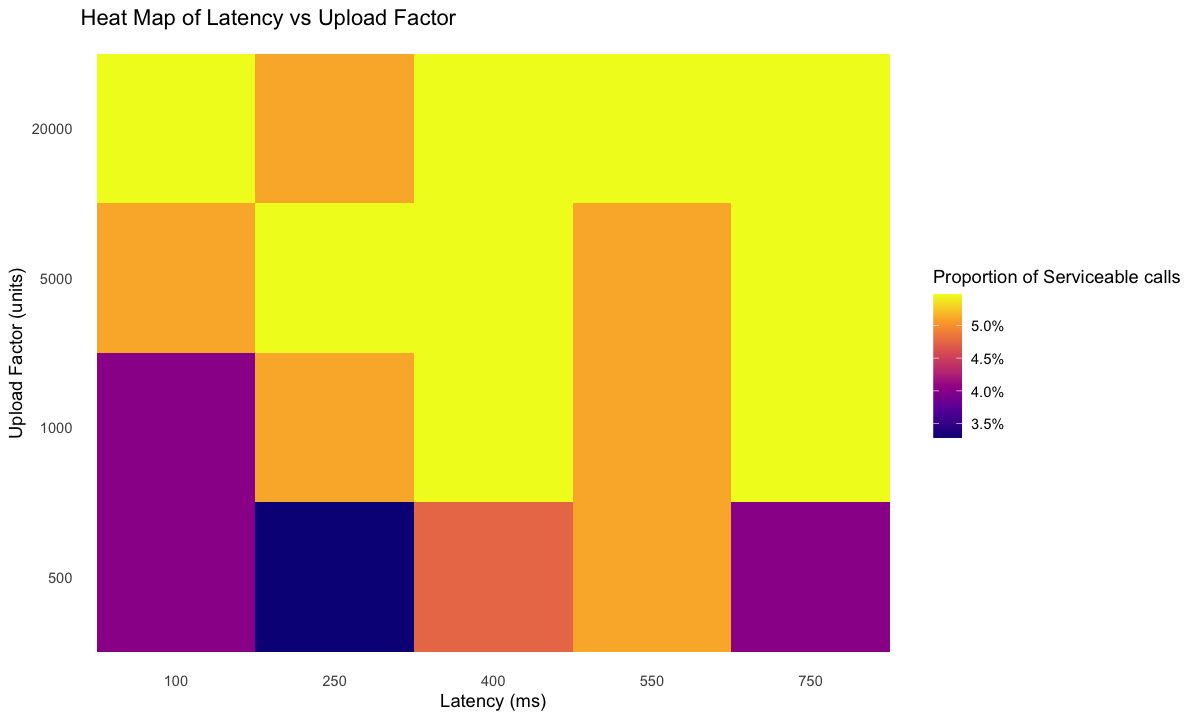

In [25]:
library(ggplot2)
total_points <- nrow(serv1)
options(repr.plot.width = 10, repr.plot.height = 6)
# Create a heat map with proportions
ggplot(data = serv1, aes(x = Latency_Factor, y = Upload_Factor)) +
    stat_bin2d(bins = 30, aes(fill = ..count../total_points)) +  # Calculate proportion
    scale_fill_viridis_c(option = "plasma", labels = scales::percent) +  # Display as percentages
    labs(title = "Heat Map of Latency vs Upload Factor",
         x = "Latency (ms)",                       
         y = "Upload Factor (units)",              
         fill = "Proportion of Serviceable calls") +                    # Legend title showing proportion
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())


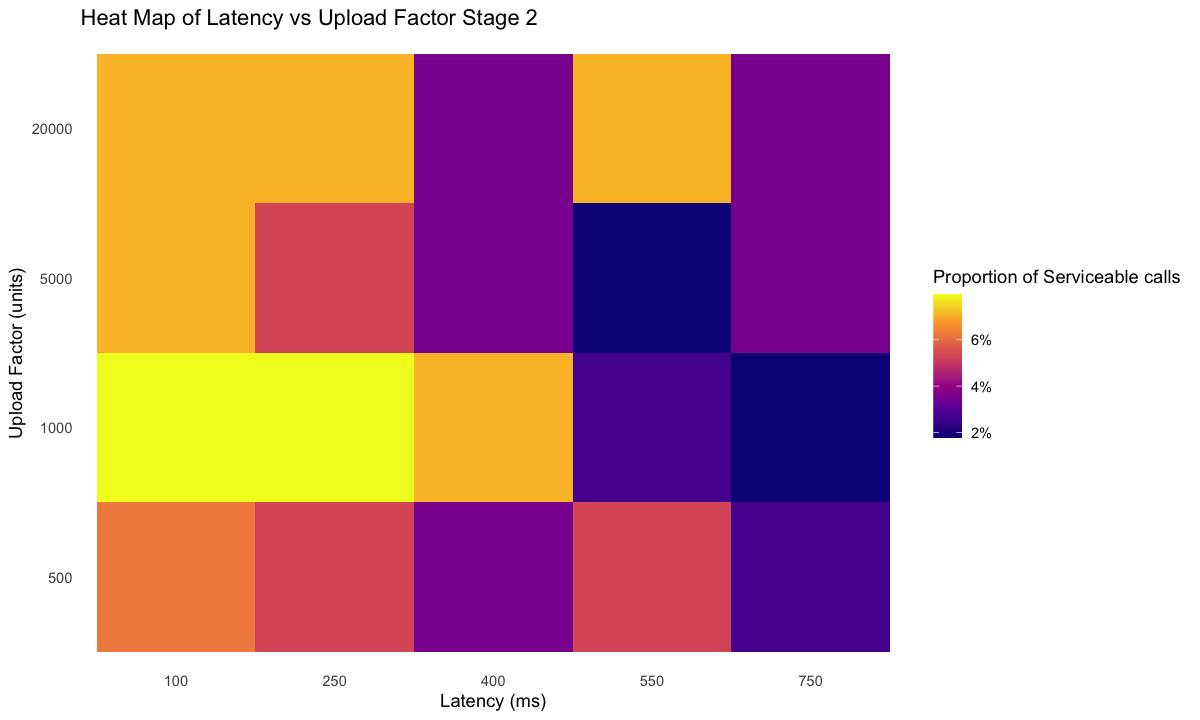

In [40]:
total_points <- nrow(serv2)
options(repr.plot.width = 10, repr.plot.height = 6)
# Create a heat map with proportions
ggplot(data = serv2, aes(x = Latency_Factor, y = Upload_Factor)) +
    stat_bin2d(bins = 30, aes(fill = ..count../total_points)) +  # Calculate proportion
    scale_fill_viridis_c(option = "plasma", labels = scales::percent) +  # Display as percentages
    labs(title = "Heat Map of Latency vs Upload Factor Stage 2",
         x = "Latency (ms)",                       
         y = "Upload Factor (units)",              
         fill = "Proportion of Serviceable calls") +                    # Legend title showing proportion
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())


# visualise Stages 1 and 2

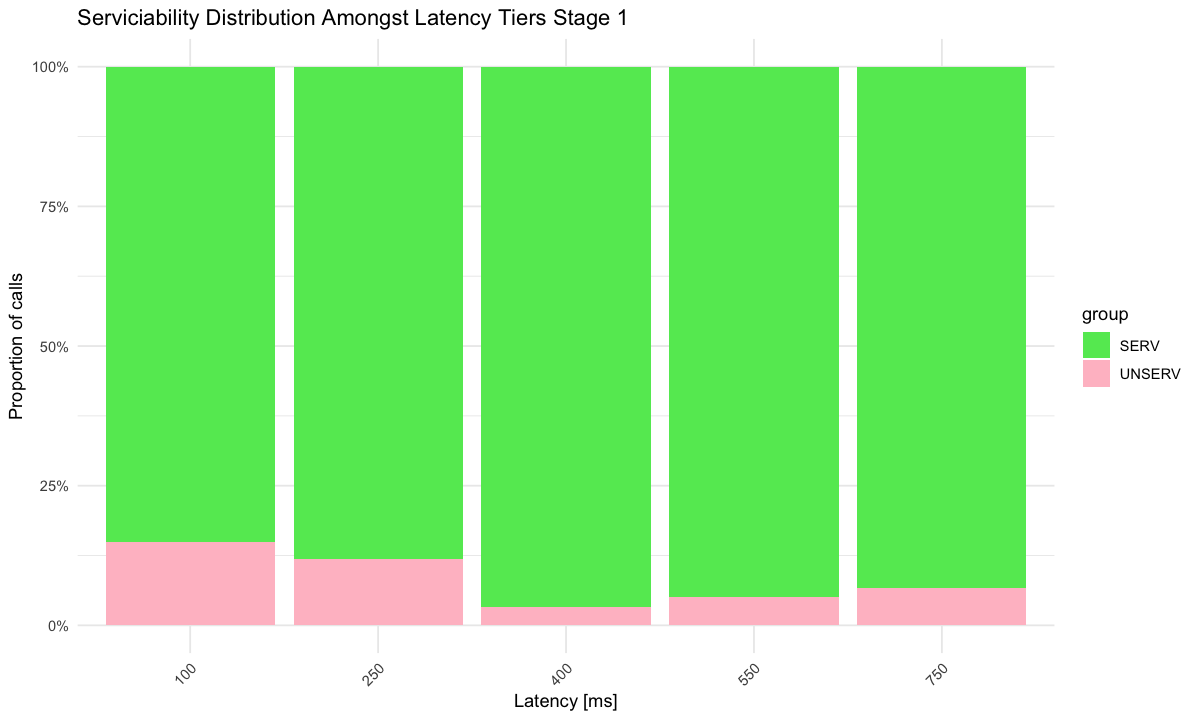

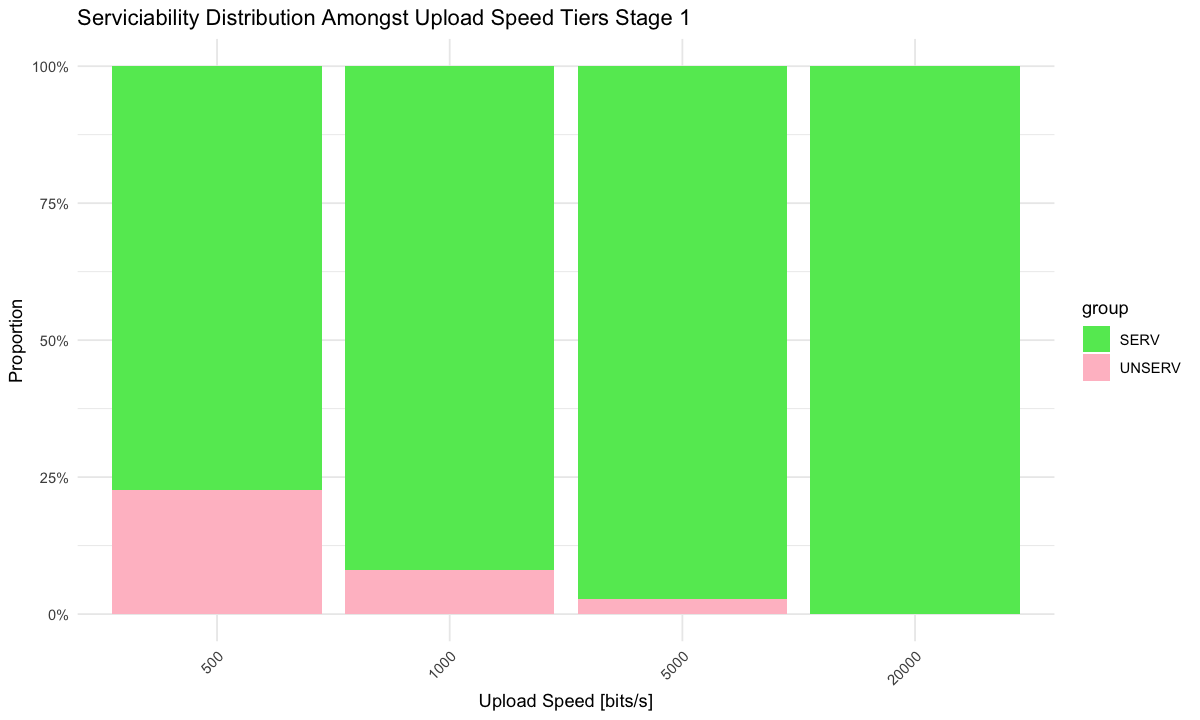

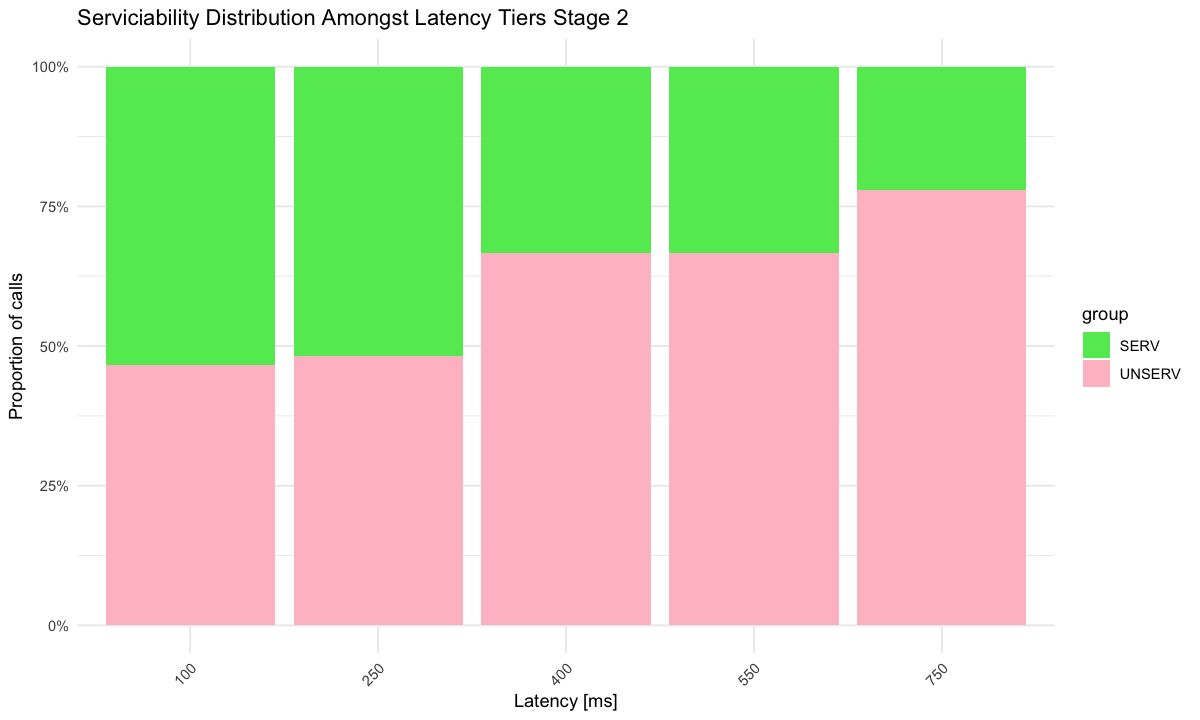

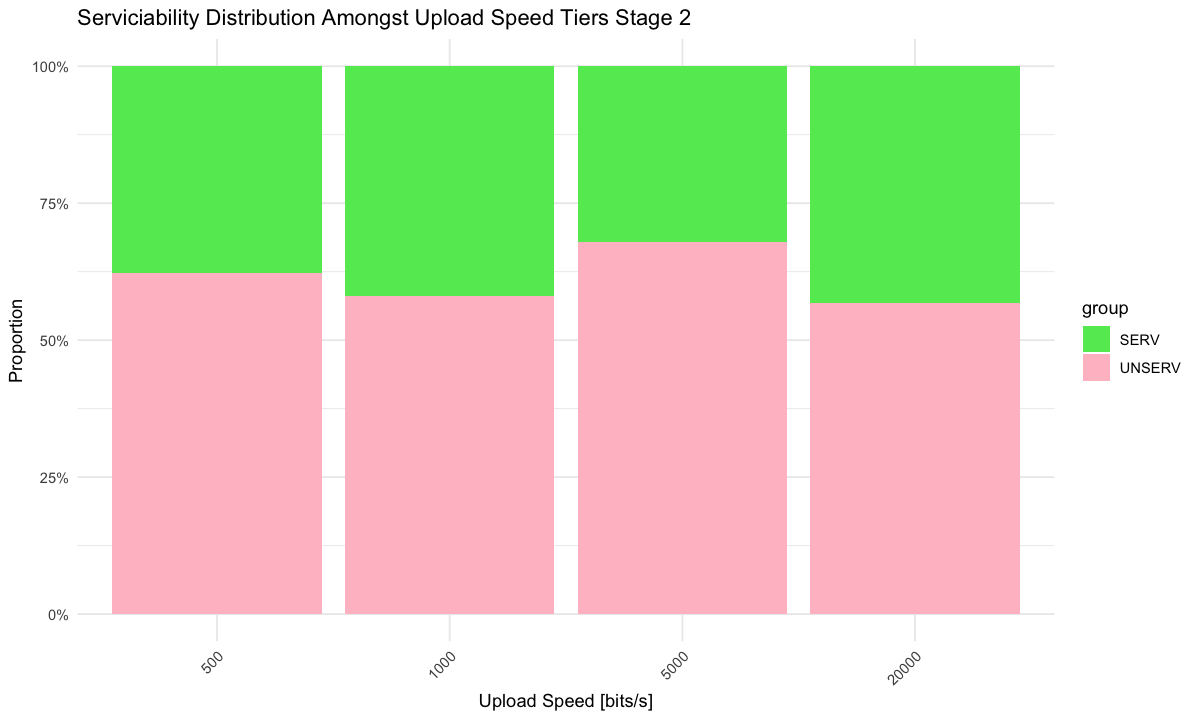

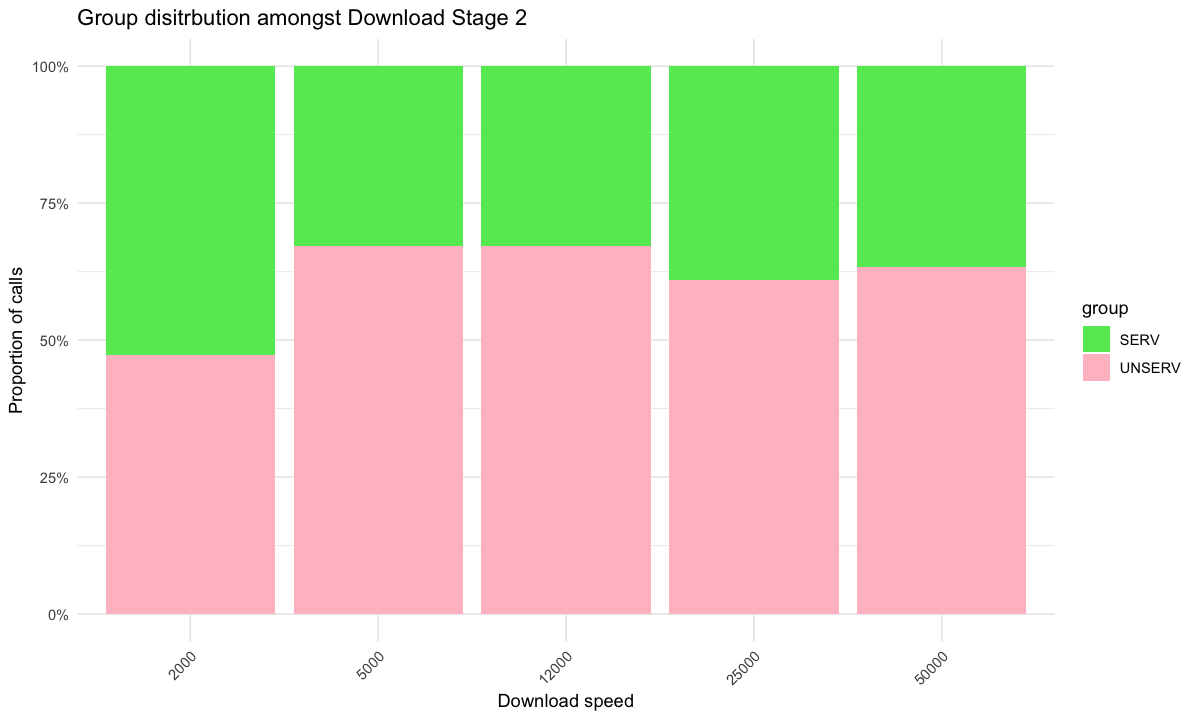

In [27]:
library(ggplot2)

plot_grouped_stacked_bars <- function(data, stage_name) {
  custom_colors <- c("UNSERV" = "pink", "SERV" = "#61e861")
  options(repr.plot.width = 10, repr.plot.height = 6)

  # Plot for Latency Factor
  p1 <- ggplot(data, aes(x = Latency_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviciability Distribution Amongst Latency Tiers", stage_name),
         x = "Latency [ms]",
         y = "Proportion of calls") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

  # Plot for Upload Factor
  p2 <- ggplot(data, aes(x = Upload_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviciability Distribution Amongst Upload Speed Tiers", stage_name),
         x = "Upload Speed [bits/s]",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  #download
  p3 <- ggplot(data, aes(x = Download_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Group disitrbution amongst Download", stage_name),
         x = "Download speed",
         y = "Proportion of calls") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

  return(list(latency_plot = p1, upload_plot = p2, download_plot =p3))
}

#make plots
plots_stage_1 <- plot_grouped_stacked_bars(combined_data1, "Stage 1")
plots_stage_2 <- plot_grouped_stacked_bars(combined_data2, "Stage 2")

#print plots
print(plots_stage_1$latency_plot)
print(plots_stage_1$upload_plot)

print(plots_stage_2$latency_plot)
print(plots_stage_2$upload_plot)
print(plots_stage_2$download_plot)

# Visualise Stage 3

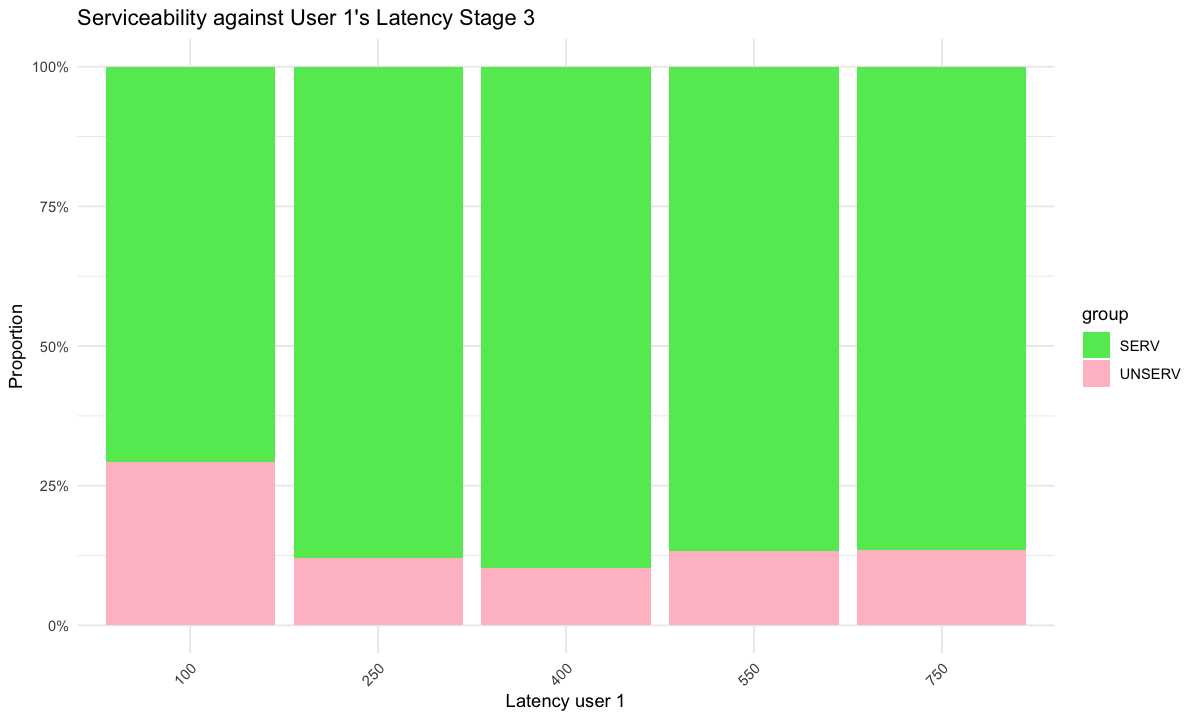

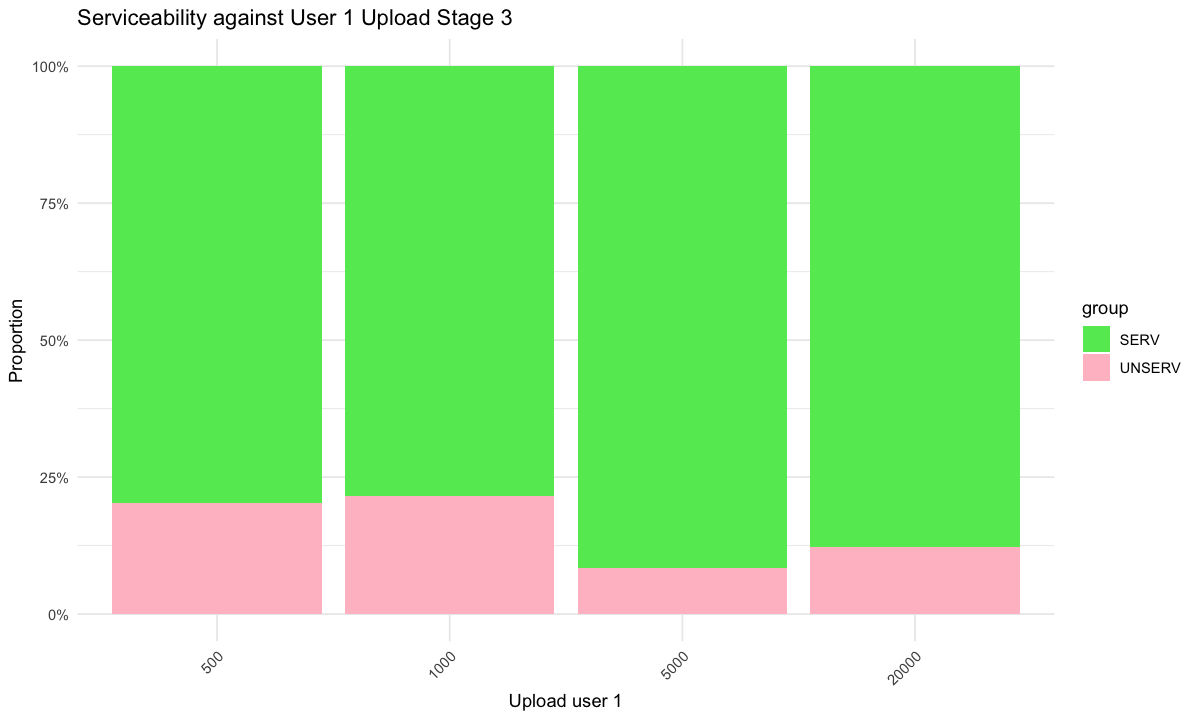

In [32]:
library(ggplot2)

plot_stage_3 <- function(data, stage_name) {
  custom_colors <- c("UNSERV" = "pink", "SERV" = "#61e861")
  options(repr.plot.width = 10, repr.plot.height = 6)

  # Plot for Latency Factor
  p1 <- ggplot(data, aes(x = Latency_Factor_x, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 1's Latency", stage_name),
         x = "Latency user 1",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

p2 <- ggplot(data, aes(x = Latency_Factor_y, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 2's Latency", stage_name),
         x = "Latency user 2",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


  # Plot for Upload Factor
  p3 <- ggplot(data, aes(x = Upload_Factor_x, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 1 Upload", stage_name),
         x = "Upload user 1",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  p4 <- ggplot(data, aes(x = Upload_Factor_y, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 2 Upload", stage_name),
         x = "Upload user 2",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  return(list(latency_plot_x = p1,latency_plot_y = p2, upload_plot_x = p3, upload_plot_y = p4))
}

#make plots
plots_stage_3 <- plot_stage_3(combined_data3, "Stage 3")
print(plots_stage_3$latency_plot_x)
#print(plots_stage_3$latency_plot_y)
print(plots_stage_3$upload_plot_x)
#print(plots_stage_3$upload_plot_y)